In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 5.9MB/s 


###Check GPU usage

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.8 GB  | Proc size: 188.7 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


###Create functions to load house data, extract sequences, and select appliance midpoints



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler

# Import house_key.py file which contains the id, and appliance numbers for every house.
house_key = drive.CreateFile({'id':'1mlx9QROP7yD_P-Gt3kXx0oWksJImQQjW'})
house_key.GetContentFile('house_key.py')
import house_key

house_info = house_key.make_house_info()

def import_house_data(selected_houses, appliance, house_info):
  '''Import raw house data from Drive. Resample to 1 minute intervals.
     Extract the aggregate and target appliance columns and place in
     a dataframe. Append each house to the end of the previous df.'''
  df = pd.DataFrame(columns = ['Aggregate', 'Appliance'])
  for house in selected_houses:
    id = house_info[house]['id']
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(f'house{house}.csv')
    house_df = pd.read_csv(f'house{house}.csv', parse_dates=['Time'], index_col='Time').drop(['Unix', 'Issues'], axis = 1).resample('min').mean()
    house_df = house_df[['Aggregate', house_info[house][appliance]]].dropna()
    house_df.rename(columns={house_info[house][appliance]:'Appliance'}, inplace=True)
    df = df.append(house_df, sort = False)
  return df  

def make_sequences(df, n_steps):
  """Creates list of sequences of length n_steps
     that walks forward one timestep at a time"""
  input_list = list(df['Aggregate'])
  output_list = []
  for i in range(len(input_list)):
    end_ix = i + n_steps
    if end_ix > len(input_list):
      break
    seq = input_list[i:end_ix]
    output_list.append(seq)
  X = np.array(output_list) 
  X = X.reshape(X.shape[0], X.shape[1], 1)
  return X

def make_scaled_sequences(df, n_steps):
  """Creates list of sequences of length n_steps
     that walks forward one timestep at a time"""
  stdsc = StandardScaler()
  X = stdsc.fit_transform(df[['Aggregate']])
  input_list = list(X)
  output_list = []
  for i in range(len(input_list)):
    end_ix = i + n_steps
    if end_ix > len(input_list):
      break
    seq = input_list[i:end_ix]
    output_list.append(seq)
  X = np.array(output_list) 
  X = X.reshape(X.shape[0], X.shape[1], 1)
  return X

def get_midpoints(df, n_steps):
  '''Gets midpoints of a sliding sequence'''
  app_df = df.iloc[:, 1] #Select first column to get appliance data
  app_df = app_df[n_steps//2:len(app_df)-n_steps//2]
  y = np.array(app_df)
  return y

![appliance list](https://drive.google.com/uc?export=view&id=12fOrgu6KKoICpQMSgtXm-Bi89_dafH12) 

## *REQUIRES INPUT* Specify target appliance and training/test houses. Import data for selected houses

In [0]:
appliance = 'Dishwasher'     # must be a string with first letters capitalized
training_houses = [2,3,4,5,7]    # must be a list of integers
test_house = [20]              # must be a list of integers             
n_steps = 149                  # length of sliding window. Should be an odd number

# Imports house data for target appliance and places in dataframes
df_train = import_house_data(training_houses, appliance, house_info)
df_test = import_house_data(test_house, appliance, house_info)

###Create training and test input sequences and target appliance midpoints

In [0]:
# # Training sequences and midpoints
X_train = make_sequences(df_train, n_steps) 
y_train = get_midpoints(df_train, n_steps)

# Test sequences and midpoints
X_test = make_sequences(df_test, n_steps) 
y_test = get_midpoints(df_test, n_steps)

###Import a previous model (run this only if using a previously trained model. Load the h5 file first)

In [0]:
# from keras.models import load_model

# dw_model = drive.CreateFile({'id':'1KXzd4UELfXA16zU9nTxzm49-5gfzKVxs'})
# dw_model.GetContentFile('dw_cnn.h5')

# model = load_model('dw_cnn.h5')
# print(model.summary())

Using TensorFlow backend.
W0805 17:26:38.169121 139638732896128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 17:26:38.208071 139638732896128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 17:26:38.326279 139638732896128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0805 17:26:38.352815 139638732896128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instea

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 149, 1)            4         
_________________________________________________________________
conv1 (Conv1D)               (None, 142, 30)           270       
_________________________________________________________________
batch_normalization_2 (Batch (None, 142, 30)           120       
_________________________________________________________________
conv2 (Conv1D)               (None, 136, 30)           6330      
_________________________________________________________________
batch_normalization_3 (Batch (None, 136, 30)           120       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 68, 30)            0         
_________________________________________________________________
conv3 (Conv1D)               (None, 63, 40)            7240      
__________

###Build CNN model (skip if using pre-trained model)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D 
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
model.add(Conv1D(filters=30, kernel_size=7, activation = 'relu',  input_shape=(n_steps, 1), padding='same', data_format='channels_last', dilation_rate=1, name = 'conv1'))
model.add(BatchNormalization(name = 'bn1'))

model.add(Conv1D(filters=30, kernel_size=6, activation = 'relu',  padding='same', data_format='channels_last', dilation_rate=1, name = 'conv2'))
model.add(BatchNormalization(name = 'bn2'))
model.add(MaxPooling1D(name = 'mp1'))

model.add(Conv1D(filters=40, kernel_size=5, activation = 'relu',  padding='same', data_format='channels_last', dilation_rate=1, name = 'conv3'))
model.add(BatchNormalization(name = 'bn3'))

model.add(Conv1D(filters=50, kernel_size=4, activation = 'relu',  padding='same', data_format='channels_last', dilation_rate=1, name = 'conv4'))
model.add(MaxPooling1D(name = 'mp2'))
model.add(BatchNormalization(name = 'bn4'))

model.add(Conv1D(filters=50, kernel_size=4, activation = 'relu',  padding='same', data_format='channels_last', dilation_rate=1, name = 'conv5'))
model.add(BatchNormalization(name = 'bn5'))

model.add(Conv1D(filters=50, kernel_size=4, activation = 'relu',  padding='same', data_format='channels_last', dilation_rate=1, name = 'conv6'))
model.add(MaxPooling1D(name = 'mp3'))
model.add(BatchNormalization(name = 'bn6'))

model.add(Flatten(name = 'flatten'))
model.add(Dense(1200, name = 'dense1', activation = 'relu'))
model.add(Dense(1, name = 'output', activation = 'relu'))
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.00000008, decay=0.0, amsgrad=False)

model.compile(loss='mse', optimizer=adam, metrics=['mae'])

model.summary()

Using TensorFlow backend.
W0725 11:53:59.588016 140055712221056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 11:53:59.630647 140055712221056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 11:53:59.640234 140055712221056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 11:53:59.780961 140055712221056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instea

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 149, 30)           240       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 149, 30)           120       
_________________________________________________________________
conv2 (Conv1D)               (None, 149, 30)           5430      
_________________________________________________________________
bn2 (BatchNormalization)     (None, 149, 30)           120       
_________________________________________________________________
mp1 (MaxPooling1D)           (None, 74, 30)            0         
_________________________________________________________________
conv3 (Conv1D)               (None, 74, 40)            6040      
_________________________________________________________________
bn3 (BatchNormalization)     (None, 74, 40)            160       
__________

## ***REQUIRES INPUT*** Define number of epochs and batch size.  Fit model

In [0]:
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D 
# from keras.layers import BatchNormalization
# from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 1000
epochs = 100

early_stop = EarlyStopping(monitor='mean_absolute_error', min_delta=0.1, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
#checkpointer = ModelCheckpoint(filepath='/content/weights.hdf5')
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, verbose=1, callbacks=[early_stop])

model.save('conv_dnn_new.h5')

W0725 11:54:12.578414 140055712221056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/100
  13000/2242390 [..............................] - ETA: 24:19 - loss: 32893.0118 - mean_absolute_error: 24.8846

###Plot model loss (MSE)

In [0]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [0]:
history.history['loss']

###Predict appliance load for test (and training) set

Typically don't do this for the training set because of the size of data. We are only really interested in the test set. If you want to see the test set fit, include the commented code in the next 3 code blocks

In [0]:
#y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

###Calculate Mean Absolute Error (MAE) and Signal Aggregate Error (SAE)


In [0]:
def get_mae(df):
    df['abs_err']= np.abs(df.y_test-df.y_hat_test)
    mae = np.round(df.abs_err.sum()/len(df),2)
    print(f'Mean absolute error: {mae}')
    return mae

def get_sae(df):
    r = df.y_test.sum()
    r_hat = df.y_hat_test.sum()
    sae = np.round(np.abs(r_hat-r)/r, 4)
    print(f'Signal Aggregate Error: {sae}')
    return sae
  
def get_epd(df_test, y_hat_test_out):
    app_test_df = df_test.Appliance[n_steps//2:len(df_test)-n_steps//2]
    df_out =  pd.DataFrame({'Test':app_test_df,'Predicted':y_hat_test_out,}, index=app_test_df.index)
    df_out = df_out.resample('D').sum()/60
    df_out['EPD'] = np.abs(df_out.Test-df_out.Predicted)
    epd = np.round(df_out.EPD.mean(), 2)
    print(f'Average Energy Per Day Error (EPD): {epd}')
    return epd
   
y_hat_test_out = y_hat_test.reshape(y_hat_test.shape[0])

y_test_out = y_test.reshape(y_test.shape[0])

test_results = pd.DataFrame({'y_test': y_test_out, 'y_hat_test': y_hat_test_out})
  
mae = get_mae(test_results)
sae = get_sae(test_results)
epd = get_epd(df_test, y_hat_test_out)

Mean absolute error: 29.76
Signal Aggregate Error: 0.2611
Average Energy Per Day Error (EPD): 333.54


### Export test data as CSV file

In [0]:
test_csv = test_results.to_csv('dw_house2.csv', index = df_test.index, header=True)

ValueError: ignored

In [0]:
predictions = pd.DataFrame({'Dishwasher Predicted': y_hat_test_out.astype('float64'), 
                           }, index = df_test.index[n_steps//2:len(df_test)-n_steps//2])

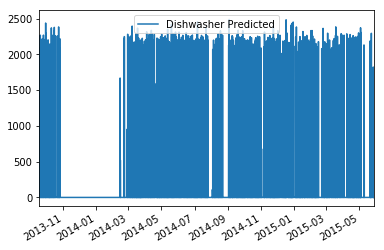

In [0]:
predictions.plot()

In [0]:
dw_out = predictions.to_csv('dw_house2.csv', index = 'Time', header=True)

###Plot Test Data and Model Predictions

In [0]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.themes import built_in_themes
from bokeh.io import curdoc

output_notebook()
curdoc().theme = 'dark_minimal'

p = figure(plot_width=1200, plot_height=600, x_axis_type="datetime")
p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Watts"

x0 = np.array(df_test.index[n_steps//2+1:len(df_test)-n_steps//2+1])
y0 = np.array(df_test.Aggregate[n_steps//2+1:len(df_test)-n_steps//2+1])

p.line(x0, y0, legend= "Aggregate", line_color='green')
p.line(x0, y_test_out, legend= "Actual", line_color='red')
p.line(x0, y_hat_test_out, legend= "Predicted", line_color='yellow')

show(p)

Loading BokehJS ...